In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import linregress


In [13]:

data_path = '../DATA/results'
mass_specs_path = '../DATA/Subhalo_mass_specs.dat'
files = [
    'Halo_11_Arm1_widths_Oct10.csv',
    'Halo_11_Arm2_widths_Oct10.csv',
    'Halo_17_Arm1_widths_Oct10.csv',
    'Halo_17_Arm2_widths_Oct10.csv',
    'Halo_198185_Arm1_widths_Oct10.csv',
    'Halo_198185_Arm2_widths_Oct10.csv',
    'Halo_418336_Arm1_widths_Oct10.csv',
    'Halo_418336_Arm2_widths_Oct10.csv',
    'Halo_167397_Arm1_widths_Oct10.csv',
    'Halo_167397_Arm2_widths_Oct10.csv',
    'Halo_117260_Arm1_widths_Oct10.csv',
    'Halo_117260_Arm2_widths_Oct10.csv',
    'Halo_198184_Arm1_widths_Oct10.csv',
    'Halo_198184_Arm2_widths_Oct10.csv',
    'Halo_289387_Arm1_widths_Oct10.csv',
    'Halo_289387_Arm2_widths_Oct10.csv',
]


In [14]:

visualizer = GalaxyArmVisualizer(data_path, files)
mass_specs_path = '../DATA/Subhalo_mass_specs.dat'
output_plot_path = "mass_vs_width.png"
visualizer.run_analysis_and_plot(mass_specs_path, output_plot_path)


In [17]:
from typing import List
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import r2_score

class GalaxyArmAnalysis:
    def __init__(self, data_path: str, file_list: List[str], mass_specs_path: str):
        self.data_path = data_path
        self.file_list = file_list
        self.mass_specs_path = mass_specs_path
        self.all_data = self.load_arm_data()
        self.mass_specs_data = self.load_mass_data()

    def load_arm_data(self) -> pd.DataFrame:
        """Load and combine arm data from specified files."""
        dataframes = []
        for file in self.file_list:
            halo_id, arm = file.split('_')[1], file.split('_')[2][3]
            df = pd.read_csv(os.path.join(self.data_path, file))
            df['halo_id'] = int(halo_id)
            df['arm'] = int(arm)
            dataframes.append(df[['halo_id', 'arm', 'x_tracing', 'y_tracing', 'w1', 'w2', 'y_max']])
        combined_data = pd.concat(dataframes, ignore_index=True)
        combined_data['width'] = combined_data['w1'] + combined_data['w2']
        return combined_data

    def load_mass_data(self) -> pd.DataFrame:
        """Load mass specifications for subhalos."""
        mass_specs_columns = [
            'subhalo_id', 'subhalo_flag', 'logmass', 'logmass0', 'logmass1', 'logmass4',
            'SubhaloCM_x', 'SubhaloCM_y', 'SubhaloCM_z',
            'SubhaloVel_x', 'SubhaloVel_y', 'SubhaloVel_z',
            'SubhaloHalfmassRad', 'MassInMaxRad', 'SubhaloVmax', 'SubhaloVmaxRad'
        ]
        return pd.read_csv(self.mass_specs_path, delim_whitespace=True, header=None, names=mass_specs_columns)

    def calculate_metrics(self) -> pd.DataFrame:
        """Calculate average metrics for each arm and subhalo and merge with mass specs."""
        width_avg_data = self.all_data.groupby(['halo_id', 'arm'])['width'].mean().reset_index()
        y_max_avg_data = self.all_data.groupby(['halo_id', 'arm'])['y_max'].mean().reset_index()
        metrics_data = pd.merge(width_avg_data, y_max_avg_data, on=['halo_id', 'arm'])
        return pd.merge(metrics_data, self.mass_specs_data, left_on='halo_id', right_on='subhalo_id')

    def origin_style_plot(self, x, y, xlabel, ylabel, title, color, marker='o', label=None, alpha=0.7):
        """Customized plotting function with Origin-inspired four-axis styling."""
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(x, y, color=color, label=label, alpha=alpha, marker=marker, edgecolor='black', s=60)

        # Styling for Origin-inspired layout with 4 visible axes
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_title(title, fontsize=18, weight='bold')
        return fig, ax

    def plot_separate_and_combined(self, merged_data: pd.DataFrame, y_property: str, x_property: str):
        """Generate separate and combined plots for arm and subhalo averages."""
        
        # Plot 1: Per arm and per subhalo
        fig, ax = self.origin_style_plot(
            merged_data[x_property], merged_data[y_property], x_property, y_property,
            f"{y_property} vs {x_property} per Arm and Subhalo", 'tab:blue'
        )
        for i, halo_id in enumerate(merged_data['halo_id'].unique()):
            sub_data = merged_data[merged_data['halo_id'] == halo_id]
            for arm in sub_data['arm'].unique():
                arm_data = sub_data[sub_data['arm'] == arm]
                ax.scatter(arm_data[x_property], arm_data[y_property], label=f'Subhalo {halo_id} Arm {arm}', alpha=0.6, s=50)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
        fig.savefig(f"{y_property}_vs_{x_property}_per_arm_subhalo.png", format='png', dpi=300)
        plt.close(fig)

        # Plot 2: Per subhalo average only
        subhalo_avg = merged_data.groupby('halo_id').agg({y_property: 'mean', x_property: 'mean'}).reset_index()
        fig, ax = self.origin_style_plot(
            subhalo_avg[x_property], subhalo_avg[y_property], x_property, y_property,
            f"{y_property} vs {x_property} per Subhalo Average", 'tab:green'
        )
        ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='green', s=60, edgecolor='black', alpha=0.8, marker='X')
        fig.savefig(f"{y_property}_vs_{x_property}_per_subhalo_avg.png", format='png', dpi=300)
        plt.close(fig)

        # Plot 3: Combined per arm and subhalo average in one
        fig, ax = self.origin_style_plot(
            merged_data[x_property], merged_data[y_property], x_property, y_property,
            f"{y_property} vs {x_property} Combined", 'tab:purple'
        )
        # Per arm plot
        for i, halo_id in enumerate(merged_data['halo_id'].unique()):
            sub_data = merged_data[merged_data['halo_id'] == halo_id]
            for arm in sub_data['arm'].unique():
                arm_data = sub_data[sub_data['arm'] == arm]
                ax.scatter(arm_data[x_property], arm_data[y_property], alpha=0.6, s=50, label=f'Subhalo {halo_id} Arm {arm}')
        # Subhalo average plot
        ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='lime', s=70, edgecolor='black', alpha=0.9, marker='X', label="Subhalo Average")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
        fig.savefig(f"{y_property}_vs_{x_property}_combined.png", format='png', dpi=300)
        plt.close(fig)

    def analyze_and_plot_all(self):
        """Perform full analysis and generate all plots."""
        merged_data = self.calculate_metrics()
        properties_to_compare = ['logmass', 'SubhaloVmaxRad']  # x-axis properties
        for x_property in properties_to_compare:
            self.plot_separate_and_combined(merged_data, 'width', x_property)
            self.plot_separate_and_combined(merged_data, 'y_max', x_property)


# Initialize analysis and run
analysis = GalaxyArmAnalysis(data_path, files, mass_specs_path)
analysis.analyze_and_plot_all()


In [18]:
# Step 1: Load libraries and define basic setup functions.
# This segment sets up the data paths and import libraries

from typing import List
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import r2_score

# Configure plot style for visibility
plt.style.use('seaborn-darkgrid')

# Set a custom color map for consistent color accessibility
color_map = cm.get_cmap('tab20')  # Color map suitable for multiple unique values


In [19]:
# Step 2: Define class for data loading and metric calculations

class GalaxyArmAnalysis:
    def __init__(self, data_path: str, file_list: List[str], mass_specs_path: str):
        self.data_path = data_path
        self.file_list = file_list
        self.mass_specs_path = mass_specs_path
        self.all_data = self.load_arm_data()
        self.mass_specs_data = self.load_mass_data()

    def load_arm_data(self) -> pd.DataFrame:
        """Load and combine arm data from specified files."""
        dataframes = []
        for file in self.file_list:
            halo_id, arm = file.split('_')[1], file.split('_')[2][3]
            df = pd.read_csv(os.path.join(self.data_path, file))
            df['halo_id'] = int(halo_id)
            df['arm'] = int(arm)
            dataframes.append(df[['halo_id', 'arm', 'x_tracing', 'y_tracing', 'w1', 'w2', 'y_max']])
        combined_data = pd.concat(dataframes, ignore_index=True)
        combined_data['width'] = combined_data['w1'] + combined_data['w2']
        return combined_data

    def load_mass_data(self) -> pd.DataFrame:
        """Load mass specifications for subhalos."""
        mass_specs_columns = [
            'subhalo_id', 'subhalo_flag', 'logmass', 'logmass0', 'logmass1', 'logmass4',
            'SubhaloCM_x', 'SubhaloCM_y', 'SubhaloCM_z',
            'SubhaloVel_x', 'SubhaloVel_y', 'SubhaloVel_z',
            'SubhaloHalfmassRad', 'MassInMaxRad', 'SubhaloVmax', 'SubhaloVmaxRad'
        ]
        return pd.read_csv(self.mass_specs_path, delim_whitespace=True, header=None, names=mass_specs_columns)

    def calculate_metrics(self) -> pd.DataFrame:
        """Calculate average metrics for each arm and subhalo and merge with mass specs."""
        width_avg_data = self.all_data.groupby(['halo_id', 'arm'])['width'].mean().reset_index()
        y_max_avg_data = self.all_data.groupby(['halo_id', 'arm'])['y_max'].mean().reset_index()
        metrics_data = pd.merge(width_avg_data, y_max_avg_data, on=['halo_id', 'arm'])
        return pd.merge(metrics_data, self.mass_specs_data, left_on='halo_id', right_on='subhalo_id')


In [25]:
# Step 3: Define plotting functions with accessible, clear visualization principles

def origin_style_plot(x, y, xlabel, ylabel, title, color, marker='o', label=None, alpha=0.7):
    """Customized plotting function with Origin-inspired styling and good visualization practices."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, color=color, label=label, alpha=alpha, marker=marker, edgecolor='black', s=60)
    
    # Start axes at 0 for clear visual comparison
    #ax.set_xlim(left=0)
    #ax.set_ylim(bottom=0)
    
    # Styling for Origin-inspired layout with 4 visible axes
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold')
    
    return fig, ax

def plot_separate_and_combined(merged_data: pd.DataFrame, y_property: str, x_property: str):
    """Generate separate and combined plots for arm and subhalo averages with clear, accessible styling."""
    
    # Plot 1: Per arm and per subhalo
    fig, ax = origin_style_plot(
        merged_data[x_property], merged_data[y_property], x_property, y_property,
        f"{y_property} vs {x_property} per Arm and Subhalo", 'tab:blue'
    )
    for i, halo_id in enumerate(merged_data['halo_id'].unique()):
        sub_data = merged_data[merged_data['halo_id'] == halo_id]
        for arm in sub_data['arm'].unique():
            arm_data = sub_data[sub_data['arm'] == arm]
            ax.scatter(arm_data[x_property], arm_data[y_property], label=f'Subhalo {halo_id} Arm {arm}', alpha=0.7, s=50)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
    plt.show()  # Show plot for immediate visualization

    # Plot 2: Per subhalo average only
    subhalo_avg = merged_data.groupby('halo_id').agg({y_property: 'mean', x_property: 'mean'}).reset_index()
    fig, ax = origin_style_plot(
        subhalo_avg[x_property], subhalo_avg[y_property], x_property, y_property,
        f"{y_property} vs {x_property} per Subhalo Average", 'tab:green'
    )
    ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='green', s=60, edgecolor='black', alpha=0.8, marker='X')
    plt.show()

    # Plot 3: Combined per arm and subhalo average in one
    fig, ax = origin_style_plot(
        merged_data[x_property], merged_data[y_property], x_property, y_property,
        f"{y_property} vs {x_property} Combined", 'tab:purple'
    )
    # Per arm plot
    for i, halo_id in enumerate(merged_data['halo_id'].unique()):
        sub_data = merged_data[merged_data['halo_id'] == halo_id]
        for arm in sub_data['arm'].unique():
            arm_data = sub_data[sub_data['arm'] == arm]
            ax.scatter(arm_data[x_property], arm_data[y_property], alpha=0.7, s=50, label=f'Subhalo {halo_id} Arm {arm}')
    # Subhalo average plot
    ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='lime', s=70, edgecolor='black', alpha=0.9, marker='X', label="Subhalo Average")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
    plt.show()


Exploring relationships for logmass...
Analyzing Width vs logmass


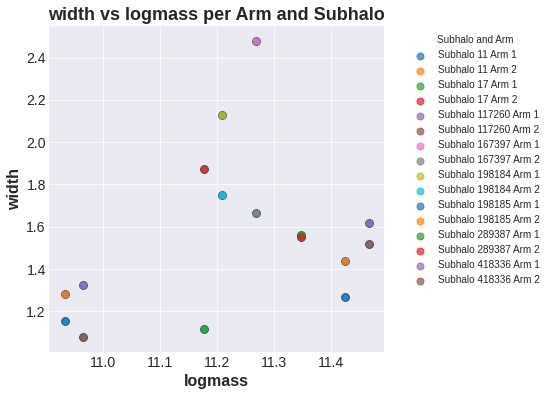

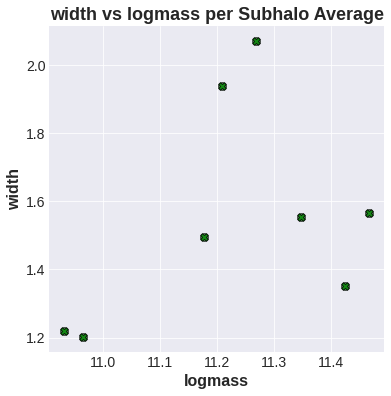

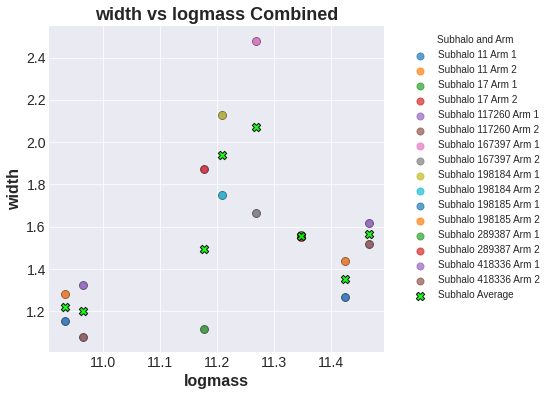

Analyzing Y_max vs logmass


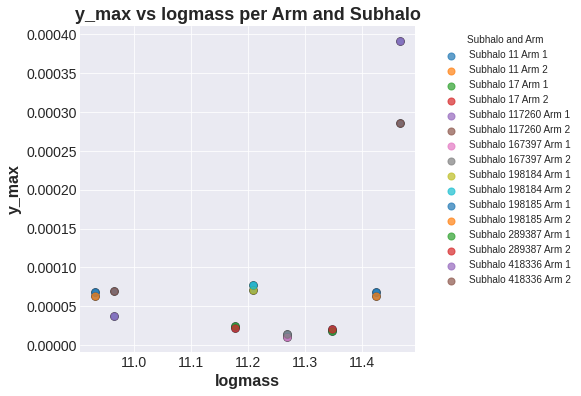

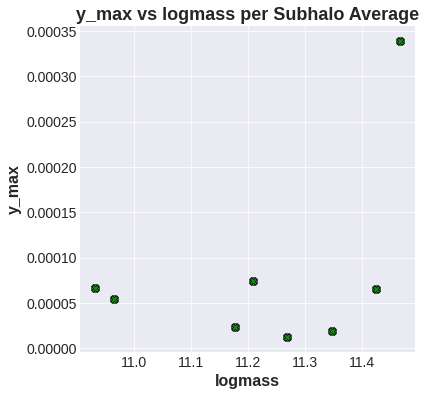

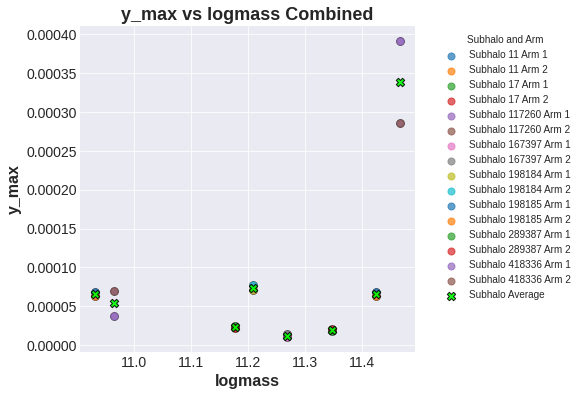

Exploring relationships for SubhaloVmaxRad...
Analyzing Width vs SubhaloVmaxRad


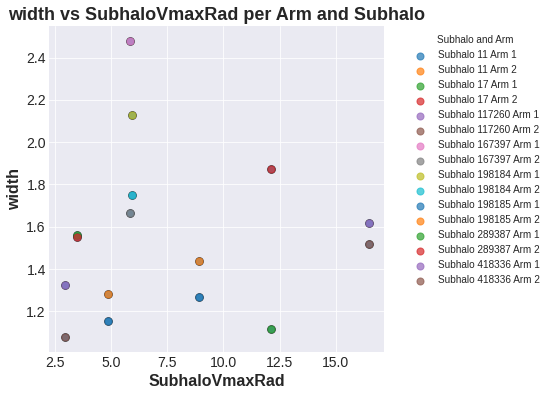

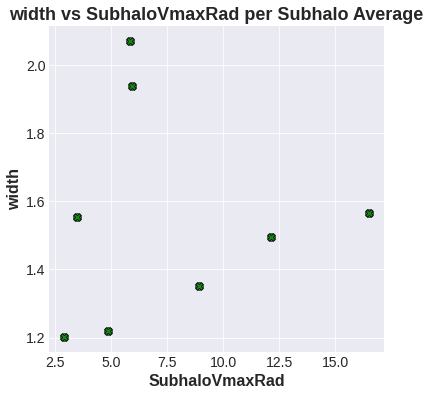

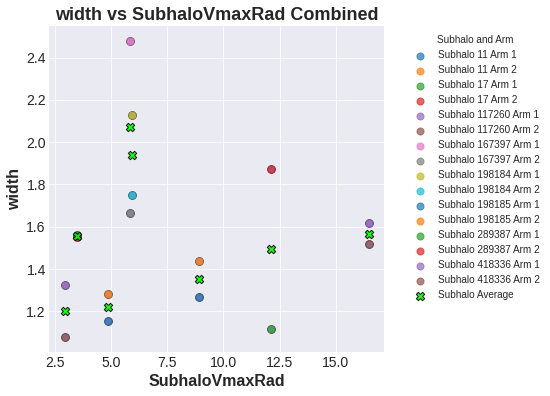

Analyzing Y_max vs SubhaloVmaxRad


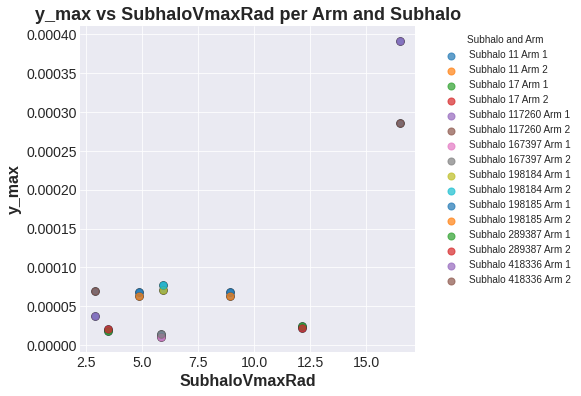

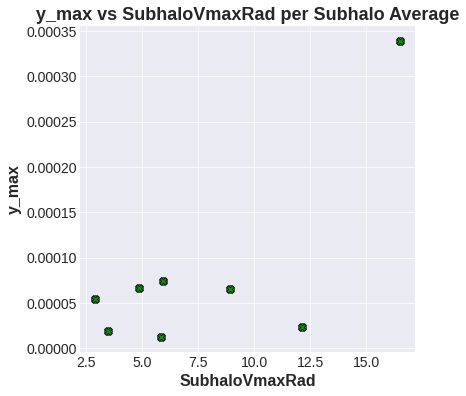

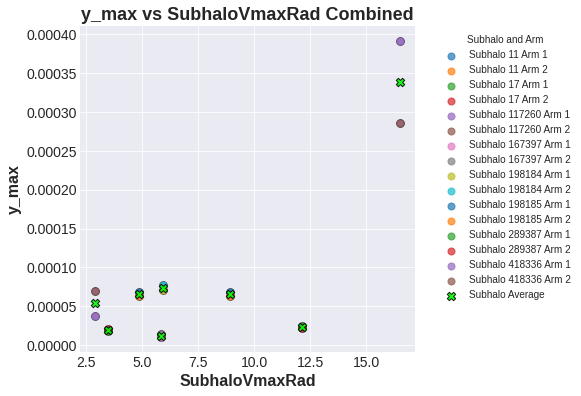

In [26]:

# Create the analysis object
analysis = GalaxyArmAnalysis(data_path, files, mass_specs_path)

# Load data and calculate merged metrics
merged_data = analysis.calculate_metrics()

# Define properties to compare (x-axis) for exploratory analysis
properties_to_compare = ['logmass', 'SubhaloVmaxRad']

# Perform and display analysis for width and y_max against selected properties
for x_property in properties_to_compare:
    print(f"Exploring relationships for {x_property}...")
    
    # Plot width vs. x_property with separate and combined views
    print(f"Analyzing Width vs {x_property}")
    plot_separate_and_combined(merged_data, 'width', x_property)
    
    # Plot y_max vs. x_property with separate and combined views
    print(f"Analyzing Y_max vs {x_property}")
    plot_separate_and_combined(merged_data, 'y_max', x_property)

Generating Pairplot for Exploratory Analysis


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

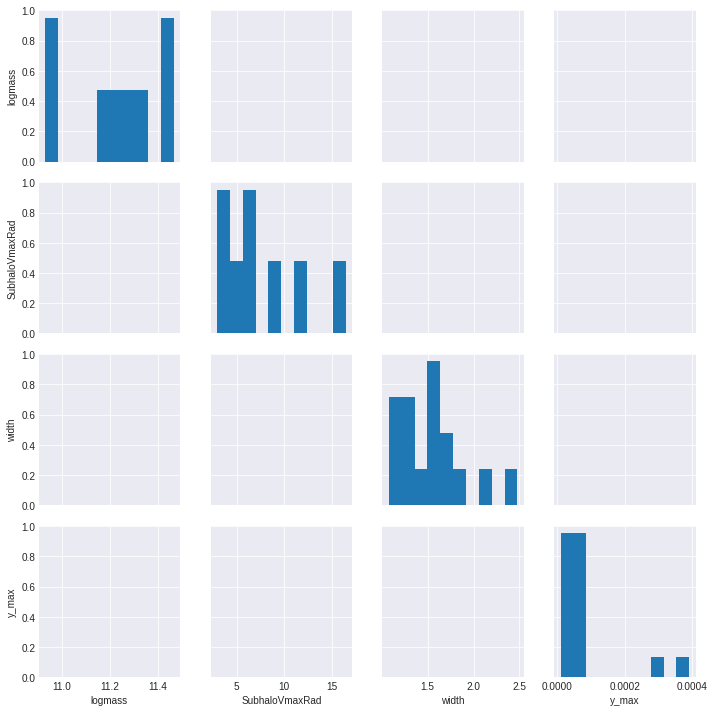

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 5: Additional exploratory analysis with pairplot and heatmap

# Create a subset of data with key properties for correlation analysis
correlation_data = merged_data[['logmass', 'SubhaloVmaxRad', 'width', 'y_max']]

# Ensure all data columns are in float64 format
correlation_data = correlation_data.astype('float64')

# Drop any rows with NaN values after conversion to ensure clean plotting
correlation_data = correlation_data.dropna()

# Pairplot to explore relationships between properties
print("Generating Pairplot for Exploratory Analysis")
sns.pairplot(correlation_data, kind="scatter", plot_kws={'alpha':0.7, 's':40, 'edgecolor':'k'})
plt.suptitle("Pairplot of Key Properties", y=1.02, fontsize=18, fontweight='bold')
plt.show()

# Heatmap to visualize correlation between properties
print("Generating Heatmap for Correlation Analysis")
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap of Key Properties", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()




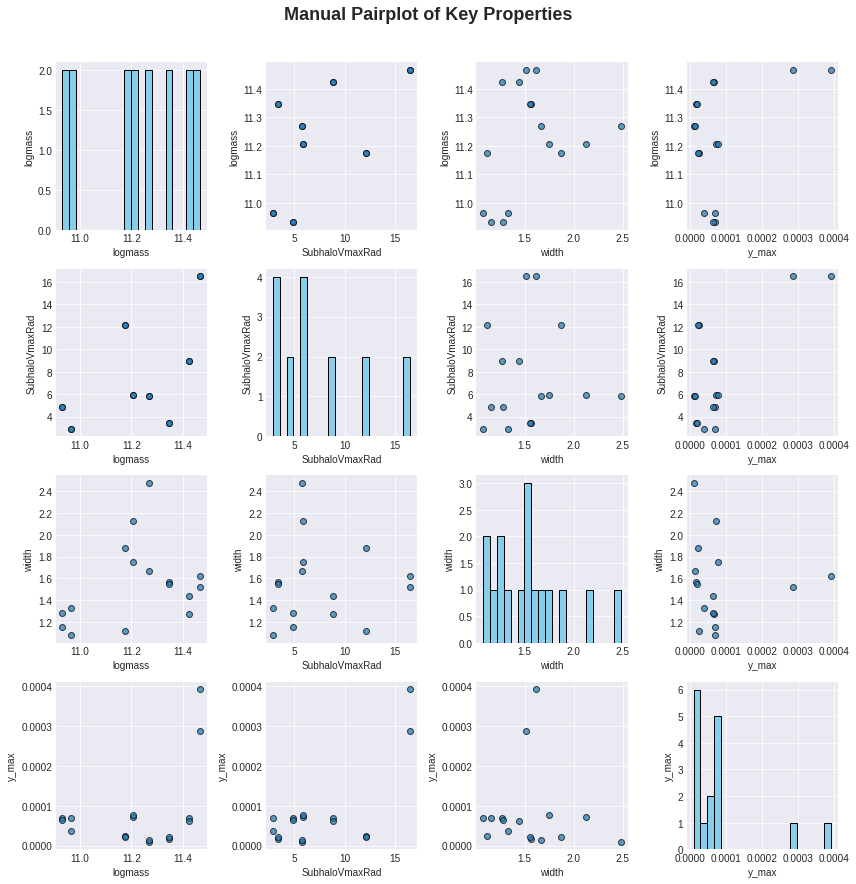

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Define pairwise plot manually for the selected data
def manual_pairplot(data):
    num_vars = data.shape[1]
    fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
    fig.suptitle("Manual Pairplot of Key Properties", fontsize=18, fontweight='bold', y=1.02)

    for i in range(num_vars):
        for j in range(num_vars):
            if i == j:
                # Plot histograms on the diagonal
                axes[i, j].hist(data.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
                axes[i, j].set_ylabel(data.columns[i])
                axes[i, j].set_xlabel(data.columns[j])
            else:
                # Plot scatter plots for pairwise relationships
                axes[i, j].scatter(data.iloc[:, j], data.iloc[:, i], alpha=0.7, edgecolor='k')
                axes[i, j].set_ylabel(data.columns[i])
                axes[i, j].set_xlabel(data.columns[j])

    plt.tight_layout()
    plt.show()

# Call the manual pairplot function with your correlation data
manual_pairplot(correlation_data)


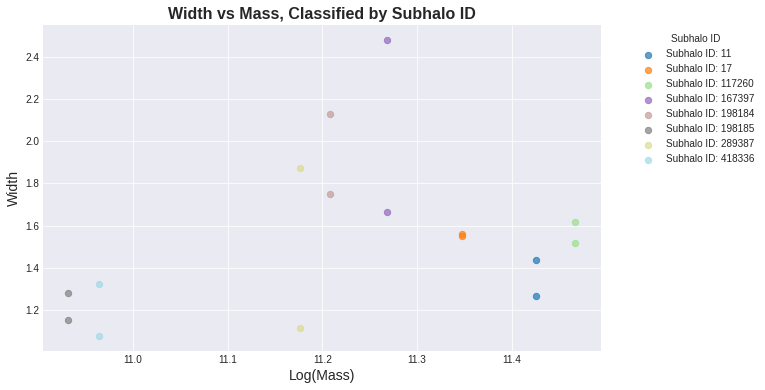

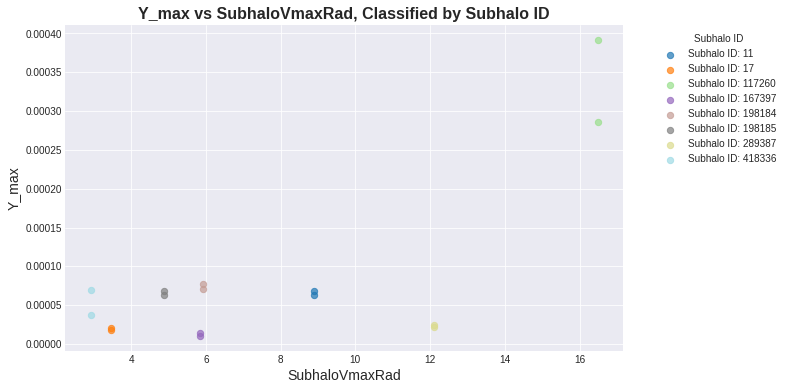

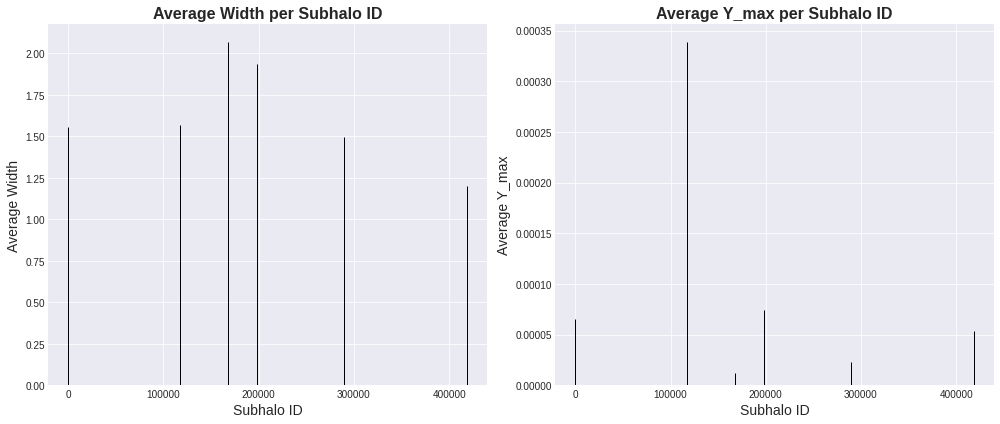

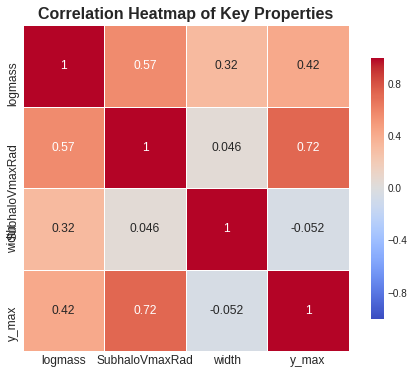

In [33]:
# Add 'halo_id' to the correlation data subset
correlation_data = merged_data[['halo_id', 'logmass', 'SubhaloVmaxRad', 'width', 'y_max']]

# Convert all data columns to ensure compatibility
correlation_data = correlation_data.astype({'halo_id': 'int64', 'logmass': 'float64', 'SubhaloVmaxRad': 'float64', 'width': 'float64', 'y_max': 'float64'})

# Re-run the visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Scatter Plot for Width vs Mass, Classified by Subhalo ID
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    plt.scatter(subset['logmass'], subset['width'], label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, s=40, color=colors(idx))

plt.title("Width vs Mass, Classified by Subhalo ID", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 2: Scatter Plot for Y_max vs SubhaloVmaxRad, Classified by Subhalo ID
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, s=40, color=colors(idx))

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 3: Bar Plot for Average Width and Y_max per Subhalo ID
avg_width = correlation_data.groupby('halo_id')['width'].mean()
avg_ymax = correlation_data.groupby('halo_id')['y_max'].mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar Plot for Width
ax[0].bar(avg_width.index, avg_width.values, color='skyblue', edgecolor='black')
ax[0].set_title("Average Width per Subhalo ID", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Subhalo ID", fontsize=14)
ax[0].set_ylabel("Average Width", fontsize=14)

# Bar Plot for Y_max
ax[1].bar(avg_ymax.index, avg_ymax.values, color='salmon', edgecolor='black')
ax[1].set_title("Average Y_max per Subhalo ID", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Subhalo ID", fontsize=14)
ax[1].set_ylabel("Average Y_max", fontsize=14)

plt.tight_layout()
plt.show()

# Step 4: Enhanced Heatmap for Correlation Analysis
correlation_matrix = correlation_data[['logmass', 'SubhaloVmaxRad', 'width', 'y_max']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap of Key Properties", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



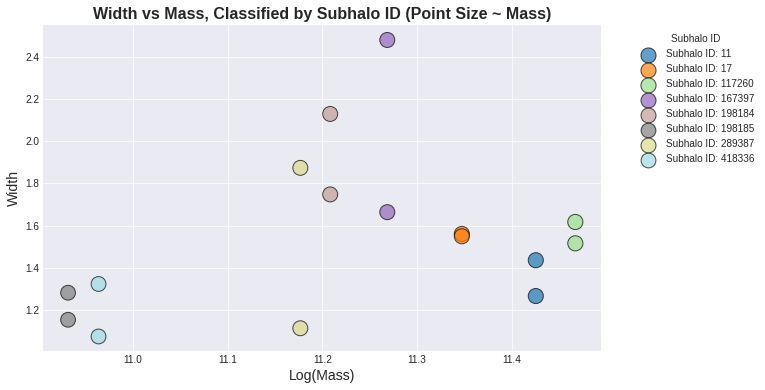

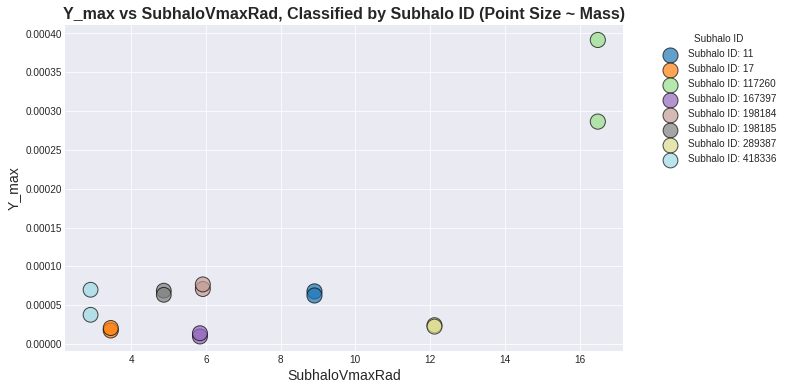

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    # Adjust point size based on 'logmass' to represent mass visually
    sizes = subset['logmass'] * 20  # Scale factor for better visualization
    plt.scatter(subset['logmass'], subset['width'], s=sizes, label=f'Subhalo ID: {subhalo_id}',
                alpha=0.7, color=colors(idx), edgecolor='k')

plt.title("Width vs Mass, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size Indicating Mass
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = subset['logmass'] * 20  # Scale factor for mass
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, color=colors(idx), edgecolor='k')

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


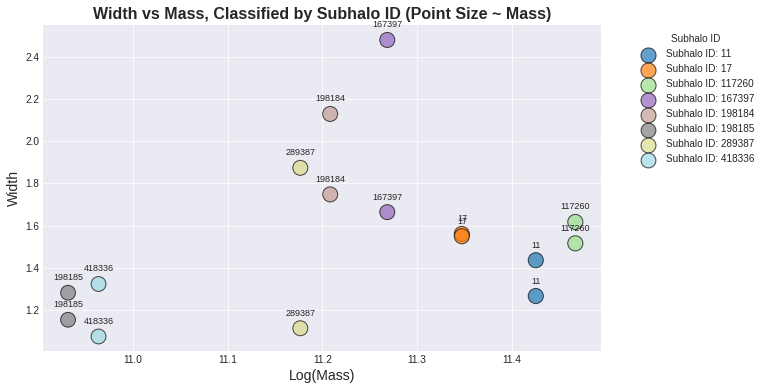

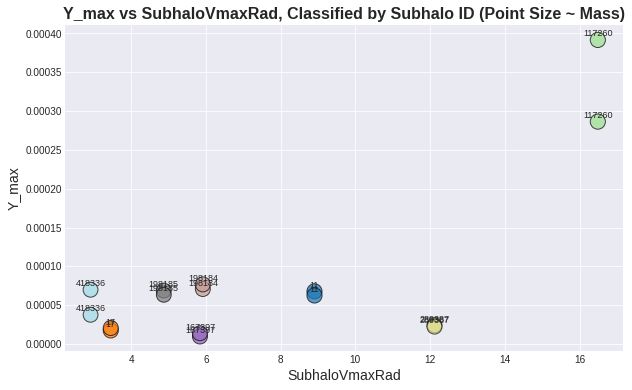

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    # Adjust point size based on 'logmass' to represent mass visually
    sizes = subset['logmass'] * 20  # Scale factor for better visualization
    plt.scatter(subset['logmass'], subset['width'], s=sizes, label=f'Subhalo ID: {subhalo_id}',
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['logmass'], row['width'] + 0.05, str(subhalo_id), ha='center', va='bottom', fontsize=9)

plt.title("Width vs Mass, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = subset['logmass'] * 20  # Scale factor for mass
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['SubhaloVmaxRad'], row['y_max'] + 0.000002, str(subhalo_id), ha='center', va='bottom', fontsize=9)

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


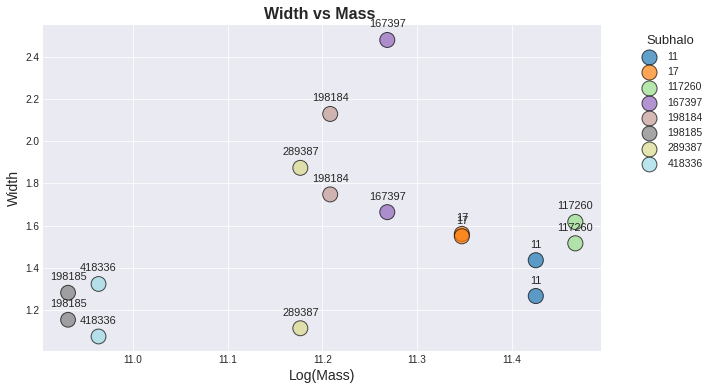

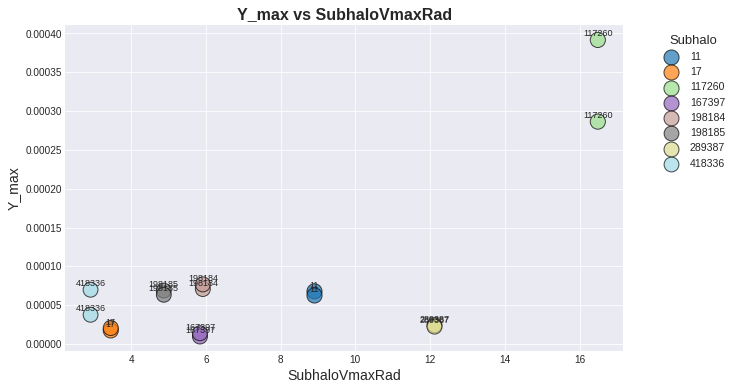

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    # Adjust point size based on 'logmass' to represent mass visually
    sizes = subset['logmass'] * 20  # Scale factor for better visualization
    plt.scatter(subset['logmass'], subset['width'], s=sizes, label=f'{subhalo_id}',
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['logmass'], row['width'] + 0.05, str(subhalo_id), ha='center', va='bottom', fontsize=11)

plt.title("Width vs Mass ", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=13, fontsize=10.5, frameon=False)
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = subset['logmass'] * 20  # Scale factor for mass
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, label=f'{subhalo_id}', 
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['SubhaloVmaxRad'], row['y_max'] + 0.000002, str(subhalo_id), ha='center', va='bottom', fontsize=9)

plt.title("Y_max vs SubhaloVmaxRad", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=13, fontsize=10.5, frameon=False)
plt.show()


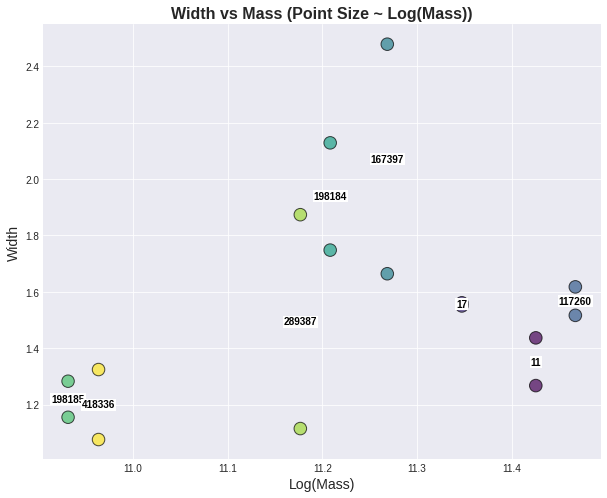

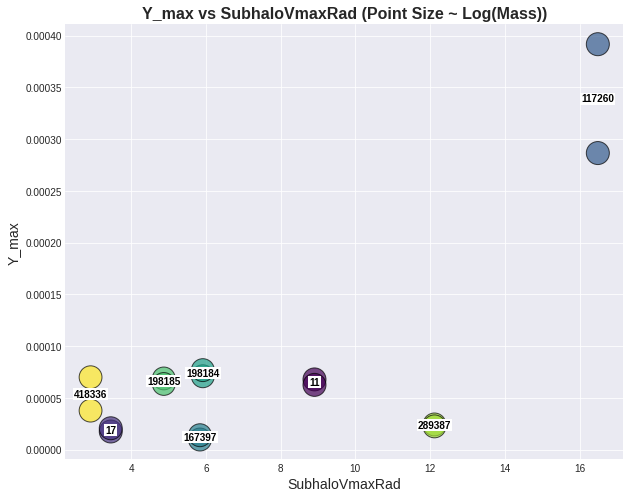

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate averages for each subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass and Average ID Labels
plt.figure(figsize=(10, 8))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))  # Using 'viridis' for better distinction

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = np.log10(subset['logmass']) * 150  # Log scale for size for better distinction
    plt.scatter(subset['logmass'], subset['width'], s=sizes, color=colors(idx), alpha=0.7, edgecolor='k')

# Add bold labels for average points only
for i, row in average_data.iterrows():
    plt.text(row['logmass'], row['width'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.title("Width vs Mass (Point Size ~ Log(Mass))", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size and Color Indicating Mass and Average ID Labels
plt.figure(figsize=(10, 8))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = np.log10(subset['logmass']) * 500  # Log scale for size
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, color=colors(idx), alpha=0.7, edgecolor='k')

# Add bold labels for average points only
for i, row in average_data.iterrows():
    plt.text(row['SubhaloVmaxRad'], row['y_max'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.title("Y_max vs SubhaloVmaxRad (Point Size ~ Log(Mass))", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.show()


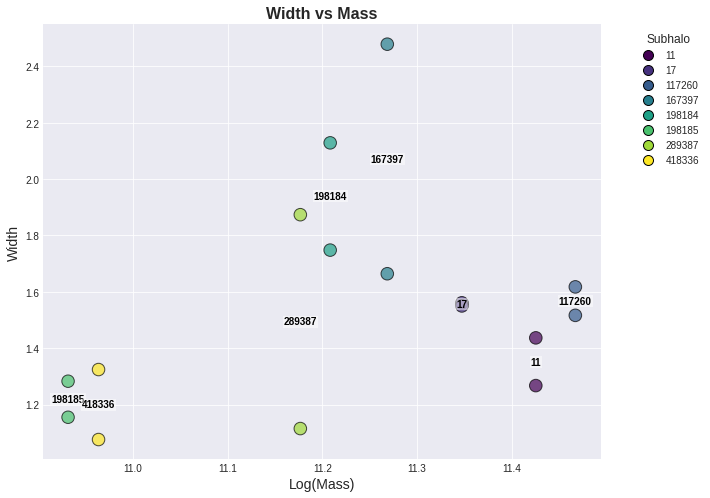

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico 1: Width vs Mass
plt.figure(figsize=(10, 8))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = np.log10(subset['logmass']) * 150  # Escala logarítmica para el tamaño
    plt.scatter(subset['logmass'], subset['width'], s=sizes, color=colors(idx), alpha=0.7, edgecolor='k')

# Etiquetas en negrita para los puntos promedio con fondo semitransparente
for i, row in average_data.iterrows():
    plt.text(row['logmass'], row['width'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5))  # Fondo con 50% de transparencia

# Añadir leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
                              markerfacecolor=colors(idx), markersize=10, markeredgecolor='k') 
                   for idx, subhalo_id in enumerate(subhalo_ids)]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Width vs Mass", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.show()



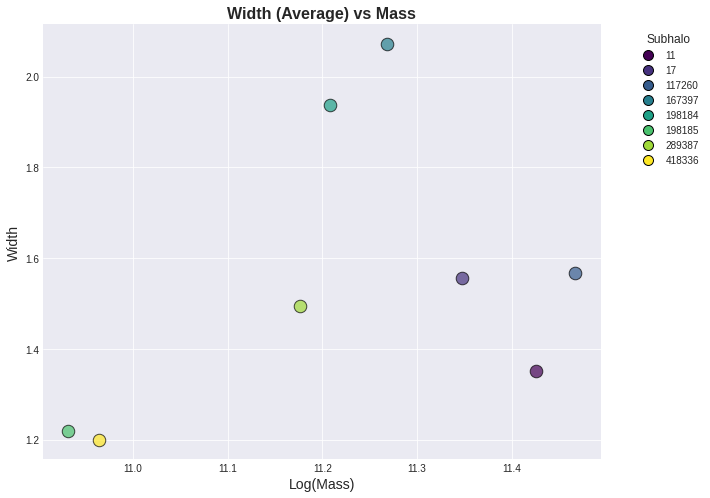

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico: Width vs Mass (solo puntos promedio)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row['logmass'], row['width'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')
# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=colors(idx), markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Width (Average) vs Mass", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.show()


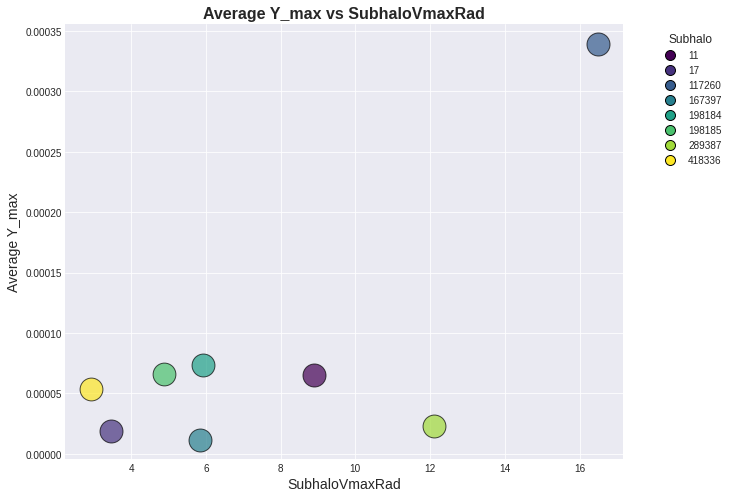

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico 2: Y_max vs SubhaloVmaxRad (solo promedios)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    size = np.log10(row['logmass']) * 500  # Escala logarítmica para el tamaño
    plt.scatter(row['SubhaloVmaxRad'], row['y_max'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')

plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Average Y_max vs SubhaloVmaxRad", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Average Y_max", fontsize=14)
plt.show()


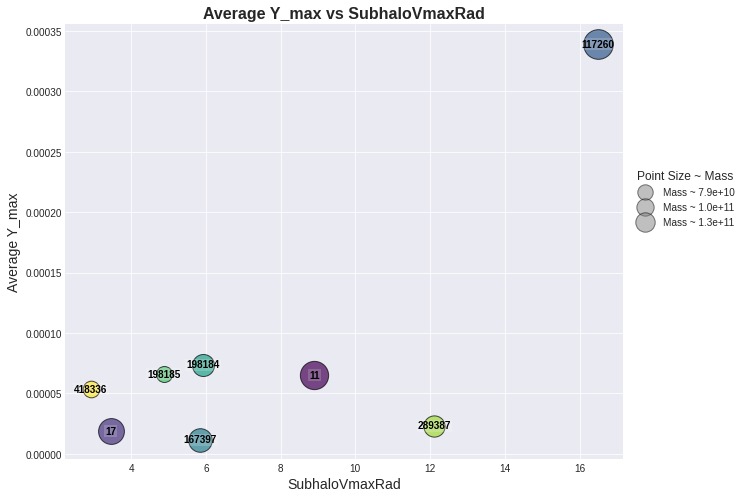

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico 2: Y_max vs SubhaloVmaxRad (solo promedios)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    # Escala de tamaño: convertir logmass a tamaño adecuado para visualizar diferencias pequeñas
    size = (10 ** (row['logmass'] - 11)) * 300  # Ajuste para que las diferencias de 0.1 se noten (~5 veces)
    plt.scatter(row['SubhaloVmaxRad'], row['y_max'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')
    # Etiqueta en negrita con fondo semitransparente para el promedio
    plt.text(row['SubhaloVmaxRad'], row['y_max'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.17))  # Fondo con 50% de transparencia

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
                              markerfacecolor=colors(idx), markersize=10, markeredgecolor='k') 
                   for idx, subhalo_id in enumerate(subhalo_ids)]

plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Crear una leyenda adicional para la escala de tamaños de puntos (masas)
# Definir tamaños representativos
mass_labels = [10**10.9, 10**11, 10**11.1]  # Escalas en logmass
size_labels = [(10 ** (np.log10(mass) - 11)) * 300 for mass in mass_labels]

# Leyenda para la escala de tamaños
for size, mass in zip(size_labels, mass_labels):
    plt.scatter([], [], s=size, color='gray', alpha=0.5, edgecolor='k',
                label=f"Mass ~ {mass:.1e}")

plt.legend(title="Point Size ~ Mass", bbox_to_anchor=(1.005, 0.6), loc='center left',
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Average Y_max vs SubhaloVmaxRad", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Average Y_max", fontsize=14)
plt.show()


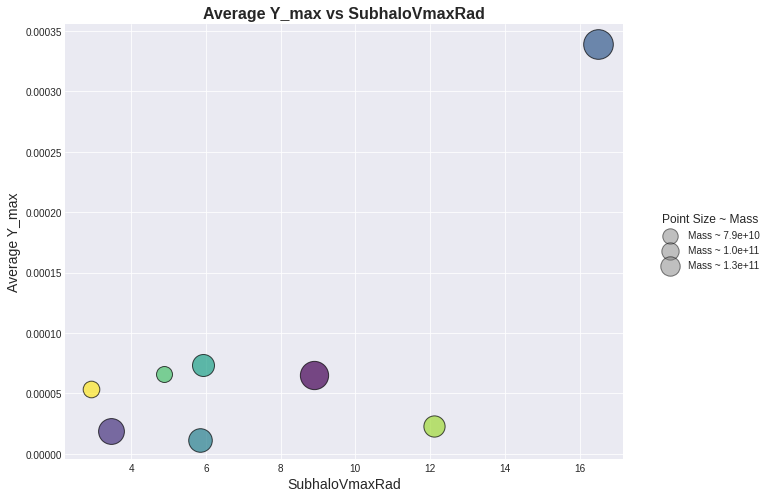

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico 2: Y_max vs SubhaloVmaxRad (solo promedios)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    # Escala de tamaño: convertir logmass a tamaño adecuado para visualizar diferencias pequeñas
    size = (10 ** (row['logmass'] - 11)) * 300  # Ajuste para que las diferencias de 0.1 se noten (~5 veces)
    plt.scatter(row['SubhaloVmaxRad'], row['y_max'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')

# Leyenda personalizada para los subhalos
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}",
           markerfacecolor=colors(idx), markersize=10, markeredgecolor='k') 
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Crear una leyenda adicional para la escala de tamaños de puntos (masas)
# Definir tamaños representativos
mass_labels = [10**10.9, 10**11, 10**11.1]  # Escalas en logmass
size_labels = [(10 ** (np.log10(mass) - 11)) * 300 for mass in mass_labels]

# Leyenda para la escala de tamaños
for size, mass in zip(size_labels, mass_labels):
    plt.scatter([], [], s=size, color='gray', alpha=0.5, edgecolor='k',
                label=f"Mass ~ {mass:.1e}")

plt.legend(title="Point Size ~ Mass", bbox_to_anchor=(1.05, 0.5), loc='center left',
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Average Y_max vs SubhaloVmaxRad", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Average Y_max", fontsize=14)
plt.show()


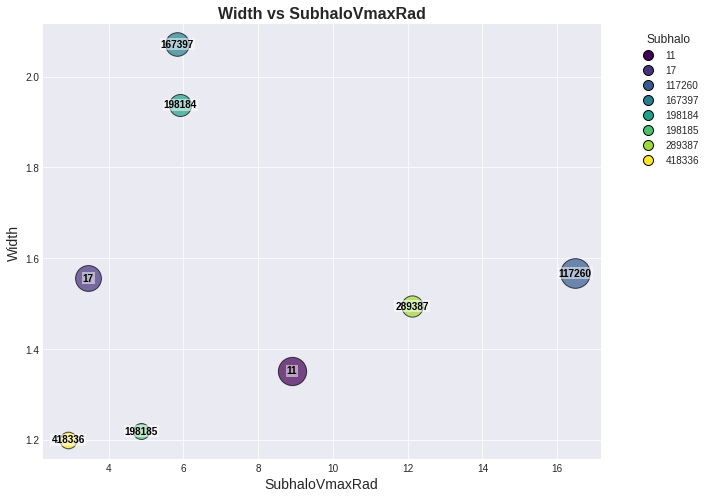

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico: Width vs SubhaloVmaxRad (solo puntos promedio)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = (10 ** (row['logmass'] - 11)) * 300
    plt.scatter(row['SubhaloVmaxRad'], row['width'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')
    # Añadir ID en negrita sobre el punto promedio
    plt.text(row['SubhaloVmaxRad'], row['width'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5))  # Fondo semitransparente

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=colors(idx), markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title("Width vs SubhaloVmaxRad", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.show()


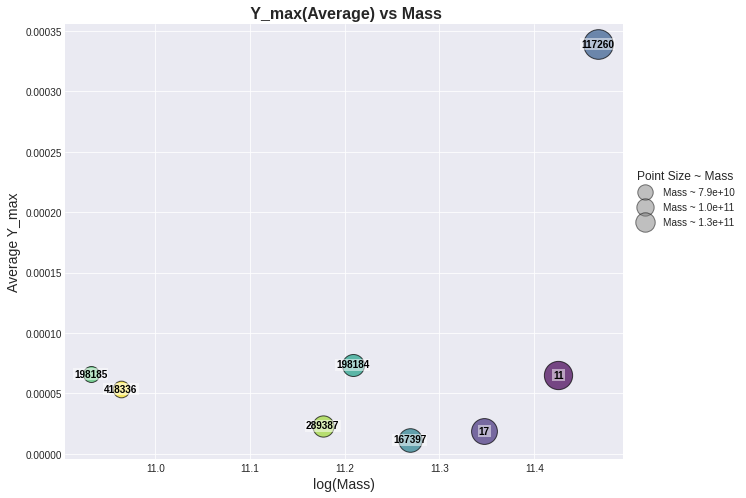

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores para cada subhalo
subhalo_ids = average_data['halo_id'].unique()
colors = plt.cm.get_cmap('viridis', len(subhalo_ids))

# Gráfico: Y_max vs log(Mass)
plt.figure(figsize=(10, 8))

for idx, row in average_data.iterrows():
    # Escala de tamaño: convertir logmass a tamaño adecuado para visualizar diferencias pequeñas
    size = (10 ** (row['logmass'] - 11)) * 300  # Ajuste para que las diferencias de 0.1 se noten (~5 veces)
    plt.scatter(row['logmass'], row['y_max'], s=size, color=colors(idx), alpha=0.7, edgecolor='k')
    # Etiqueta en negrita con fondo semitransparente para el promedio
    plt.text(row['logmass'], row['y_max'], f"{int(row['halo_id'])}", ha='center', va='center', 
             fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5))  # Fondo con 50% de transparencia

# Leyenda personalizada para los IDs de subhalos
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
                          markerfacecolor=colors(idx), markersize=10, markeredgecolor='k') 
                   for idx, subhalo_id in enumerate(subhalo_ids)]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(1.05, 1), loc='upper left', 
           title_fontsize=12, fontsize=10, frameon=False)

# Leyenda adicional para la escala de tamaños de puntos (masas)
# Definir tamaños representativos
mass_labels = [10**10.9, 10**11, 10**11.1]  # Escalas en logmass
size_labels = [(10 ** (np.log10(mass) - 11)) * 300 for mass in mass_labels]

# Leyenda para la escala de tamaños de masa
for size, mass in zip(size_labels, mass_labels):
    plt.scatter([], [], s=size, color='gray', alpha=0.5, edgecolor='k',
                label=f"Mass ~ {mass:.1e}")

plt.legend(title="Point Size ~ Mass", bbox_to_anchor=(1.005, 0.6), loc='center left',
           title_fontsize=12, fontsize=10, frameon=False)

# Etiquetas del gráfico
plt.title(" Y_max(Average) vs Mass", fontsize=16, fontweight='bold')
plt.xlabel("log(Mass)", fontsize=14)
plt.ylabel("Average Y_max", fontsize=14)
plt.show()
